# <font color=#025dfa> Derin Öğrenim Classification ile Sigorta Çapraz Satışı - Insurance Cross-Selling with Deep Learning Classification

TR = Her yorum satırı kendisini üstündeki koda aittir. İlk olarak Türkçe, son olarak İngilizce yazıldı.

EN = Each comment line belongs to the code above it. It was first written in Turkish and lastly in English.

TR = Bu proje, sigorta sektöründe çapraz satış fırsatlarını belirlemek amacıyla derin öğrenme tabanlı bir sınıflandırma modeli geliştirmeyi hedeflemektedir. Müşterilerin demografik verileri, mevcut poliçe türleri, satın alma geçmişi ve risk profilleri gibi çeşitli faktörler kullanılarak, hangi müşterilere ek sigorta ürünlerinin önerilebileceği sınıflandırılacaktır. Proje, sigorta şirketlerinin çapraz satış stratejilerini optimize ederek, müşteri memnuniyetini artırmayı ve şirketin gelirlerini maksimize etmeyi amaçlamaktadır.

EN = This project aims to develop a deep learning-based classification model to identify cross-selling opportunities in the insurance industry. Using various factors such as customer demographic data, current policy types, purchase history and risk profiles, it will classify which customers can be offered additional insurance products. The project aims to increase customer satisfaction and maximize company revenues by optimizing insurance companies' cross-selling strategies.

Kaynak/Source = https://www.kaggle.com/competitions/playground-series-s4e7

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import nltk
import warnings
warnings.filterwarnings('ignore')
import re
import pickle

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [3]:
pd.set_option("display.max_columns",None) 
# TR = En fazla kaç sütun olduğunu gösteriyor. 
# EN = It shows the maximum number of columns.

In [4]:
df=pd.read_csv('/kaggle/input/playground-series-s4e7/train.csv')

## <font color=#FFD700> EDA Keşif Amaçlı Veri Analizi - EDA - Exploratory Data Analysis 

In [5]:
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


In [6]:
df.sample(5)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
8430704,8430704,Male,47,1,8.0,0,1-2 Year,Yes,27505.0,4.0,225,0
7906959,7906959,Female,24,1,28.0,1,< 1 Year,No,33756.0,152.0,216,0
3171090,3171090,Male,23,1,47.0,0,< 1 Year,Yes,31593.0,160.0,86,0
781,781,Male,64,1,21.0,1,1-2 Year,Yes,2630.0,124.0,91,0
1422845,1422845,Male,28,1,36.0,1,< 1 Year,No,28990.0,152.0,186,0


In [7]:
df.tail()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
11504793,11504793,Male,48,1,6.0,0,1-2 Year,Yes,27412.0,26.0,218,0
11504794,11504794,Female,26,1,36.0,0,< 1 Year,Yes,29509.0,152.0,115,1
11504795,11504795,Female,29,1,32.0,1,< 1 Year,No,2630.0,152.0,189,0
11504796,11504796,Female,51,1,28.0,0,1-2 Year,Yes,48443.0,26.0,274,1
11504797,11504797,Male,25,1,28.0,1,< 1 Year,No,32855.0,152.0,189,0


In [8]:
df.shape

(11504798, 12)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11504798 entries, 0 to 11504797
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   Gender                object 
 2   Age                   int64  
 3   Driving_License       int64  
 4   Region_Code           float64
 5   Previously_Insured    int64  
 6   Vehicle_Age           object 
 7   Vehicle_Damage        object 
 8   Annual_Premium        float64
 9   Policy_Sales_Channel  float64
 10  Vintage               int64  
 11  Response              int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 1.0+ GB


In [10]:
df.isnull().sum().sort_values(ascending=False)

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [11]:
df.describe()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07
mean,5.752398e+06,3.838356e+01,9.980220e-01,2.641869e+01,4.629966e-01,3.046137e+04,1.124254e+02,1.638977e+02,1.229973e-01
std,3.321149e+06,1.499346e+01,4.443120e-02,1.299159e+01,4.986289e-01,1.645475e+04,5.403571e+01,7.997953e+01,3.284341e-01
min,0.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,2.630000e+03,1.000000e+00,1.000000e+01,0.000000e+00
25%,2.876199e+06,2.400000e+01,1.000000e+00,1.500000e+01,0.000000e+00,2.527700e+04,2.900000e+01,9.900000e+01,0.000000e+00
50%,5.752398e+06,3.600000e+01,1.000000e+00,2.800000e+01,0.000000e+00,3.182400e+04,1.510000e+02,1.660000e+02,0.000000e+00
75%,8.628598e+06,4.900000e+01,1.000000e+00,3.500000e+01,1.000000e+00,3.945100e+04,1.520000e+02,2.320000e+02,0.000000e+00
max,1.150480e+07,8.500000e+01,1.000000e+00,5.200000e+01,1.000000e+00,5.401650e+05,1.630000e+02,2.990000e+02,1.000000e+00


In [12]:
df.corr(numeric_only=True)

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,1.000000,-0.000088,-0.000045,0.000147,0.000217,-0.000205,0.000550,-0.000182,0.000018
Age,-0.000088,1.000000,-0.078519,0.037041,-0.276248,0.056327,-0.591443,-0.013293,0.122134
Driving_License,-0.000045,-0.078519,1.000000,-0.001329,0.013733,-0.007300,0.042941,-0.000697,0.009197
Region_Code,0.000147,0.037041,-0.001329,1.000000,-0.022367,-0.001741,-0.037606,-0.005537,0.012816
Previously_Insured,0.000217,-0.276248,0.013733,-0.022367,1.000000,0.007665,0.236838,0.019431,-0.345930
Annual_Premium,-0.000205,0.056327,-0.007300,-0.001741,0.007665,1.000000,-0.128559,0.003284,0.032261
Policy_Sales_Channel,0.000550,-0.591443,0.042941,-0.037606,0.236838,-0.128559,1.000000,0.008999,-0.152733
Vintage,-0.000182,-0.013293,-0.000697,-0.005537,0.019431,0.003284,0.008999,1.000000,-0.015177
Response,0.000018,0.122134,0.009197,0.012816,-0.345930,0.032261,-0.152733,-0.015177,1.000000


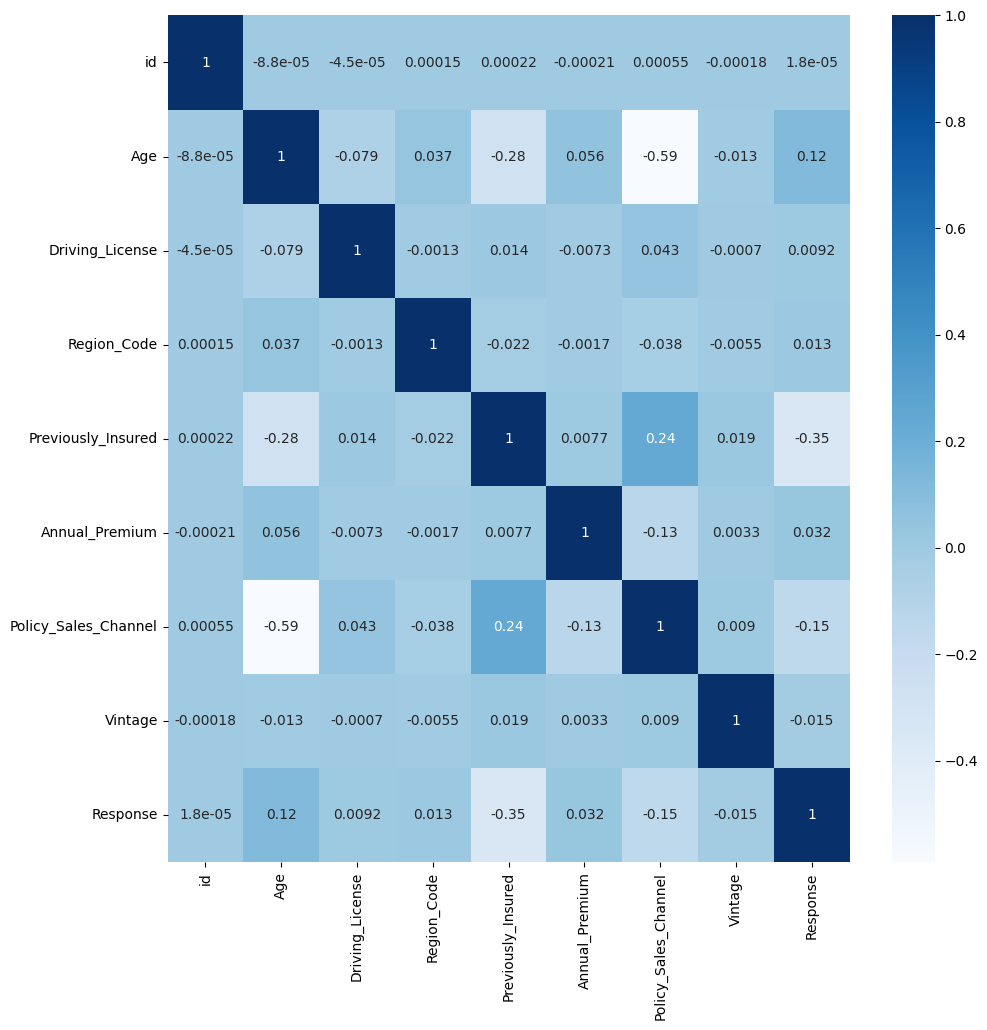

In [13]:
plt.figure(figsize=(11,11))
sns.heatmap(df.corr(numeric_only=True),annot=True,cmap='Blues');

In [14]:
abs(df.corr(numeric_only=True)['Response']).sort_values(ascending=False)

Response                1.000000
Previously_Insured      0.345930
Policy_Sales_Channel    0.152733
Age                     0.122134
Annual_Premium          0.032261
Vintage                 0.015177
Region_Code             0.012816
Driving_License         0.009197
id                      0.000018
Name: Response, dtype: float64

## <font color=#C0C0C0> Gereksiz Verileri Silme İşlemi Yapıyoruz - We Delete Unnecessary Data

In [15]:
df=df.drop(['Gender','id'],axis=1)
df.head(1)

,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0


## <font color='#8b1cc7'> Sütün İşimlerini Orjinal, Türkçe Ve İngilizce Versiyonda Göster  - Show the Processes of Milk in Original, Turkish and English Version

## <font color=#1cfc03> Aykırı Değer - Outlier

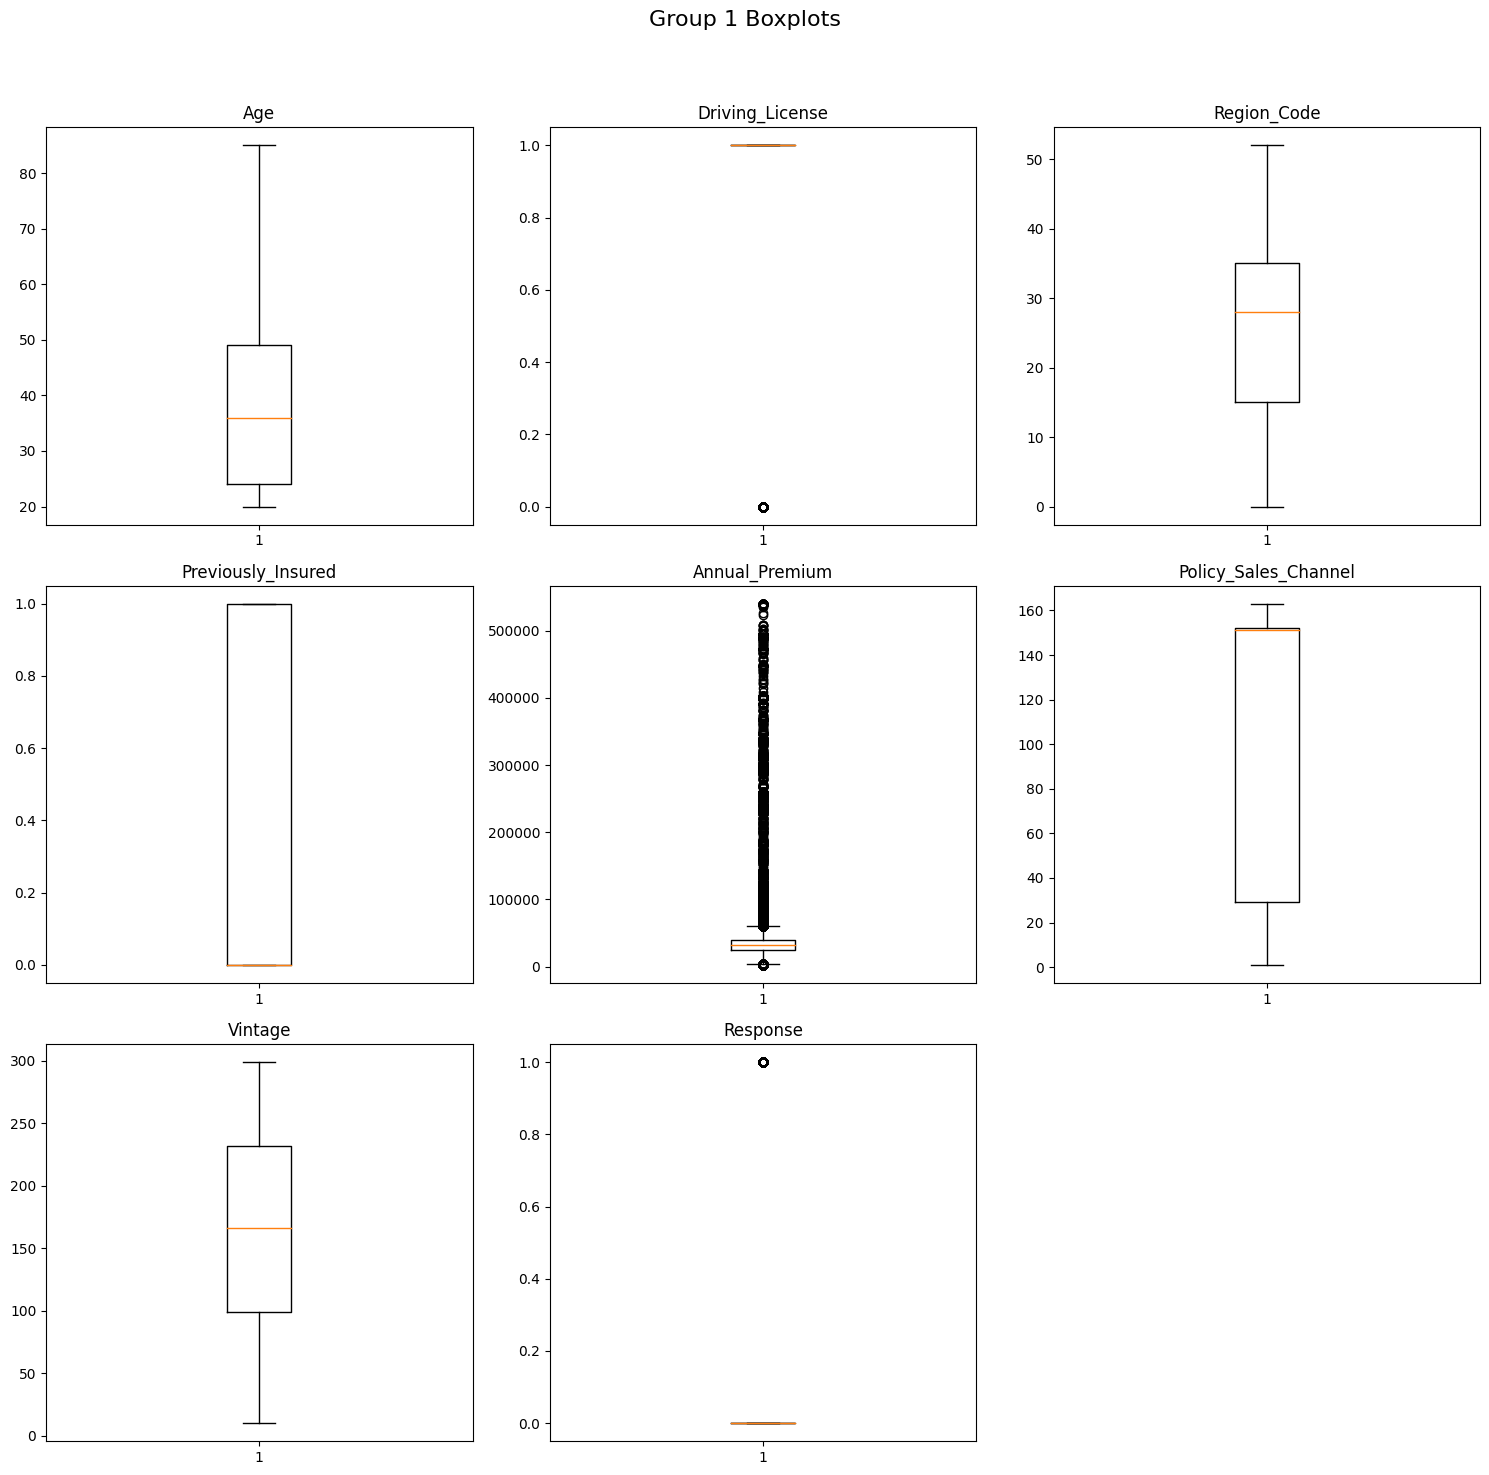

In [16]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

num_cols = len(numeric_cols)
num_plots_per_group = 9
num_groups = math.ceil(num_cols / num_plots_per_group)

for group in range(num_groups):
    cols_in_group = numeric_cols[group * num_plots_per_group:(group + 1) * num_plots_per_group]
    num_plots = len(cols_in_group)
    rows = math.ceil(num_plots / 3)
    fig, axs = plt.subplots(rows, 3, figsize=(15, 5 * rows))
    axs = axs.flatten() if num_plots > 1 else [axs]

    for i, col in enumerate(cols_in_group):
        axs[i].boxplot(df[col].dropna())
        axs[i].set_title(col)

    for i in range(num_plots, len(axs)):
        axs[i].set_visible(False)  

    plt.suptitle(f'Group {group + 1} Boxplots', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])


In [17]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns  
# TR = Veri setindeki sayısal sütunları (float64 ve int64 türündeki sütunları) seçer  
# EN = Selects numeric columns from the dataset (float64 and int64 types)

for col in numeric_cols:  
    # TR = Her bir sayısal sütun için döngü başlatır  
    # EN = Loops through each numeric column

    percentile_85 = df[col].quantile(0.90)  
    # TR = Sütundaki 85. yüzdelik dilim değerini hesaplar  
    # EN = Calculates the 85th percentile value for the column

    outlier_count = (df[col] > percentile_85).sum()  
    # TR = 85. yüzdelik dilimden büyük olan değerlerin sayısını bulur  
    # EN = Counts how many values are greater than the 85th percentile

    total_rows = len(df)  
    # TR = Veri setindeki toplam satır sayısını alır  
    # EN = Gets the total number of rows in the dataset

    if outlier_count < total_rows:  
        # TR = Eğer aykırı değer sayısı toplam satır sayısından azsa  
        # EN = If the outlier count is less than the total number of rows

        df = df[df[col] <= percentile_85]  
        # TR = 85. yüzdelik dilimden küçük veya eşit olan değerleri tutarak veri setini filtreler  
        # EN = Filters the dataset to keep only values less than or equal to the 85th percentile

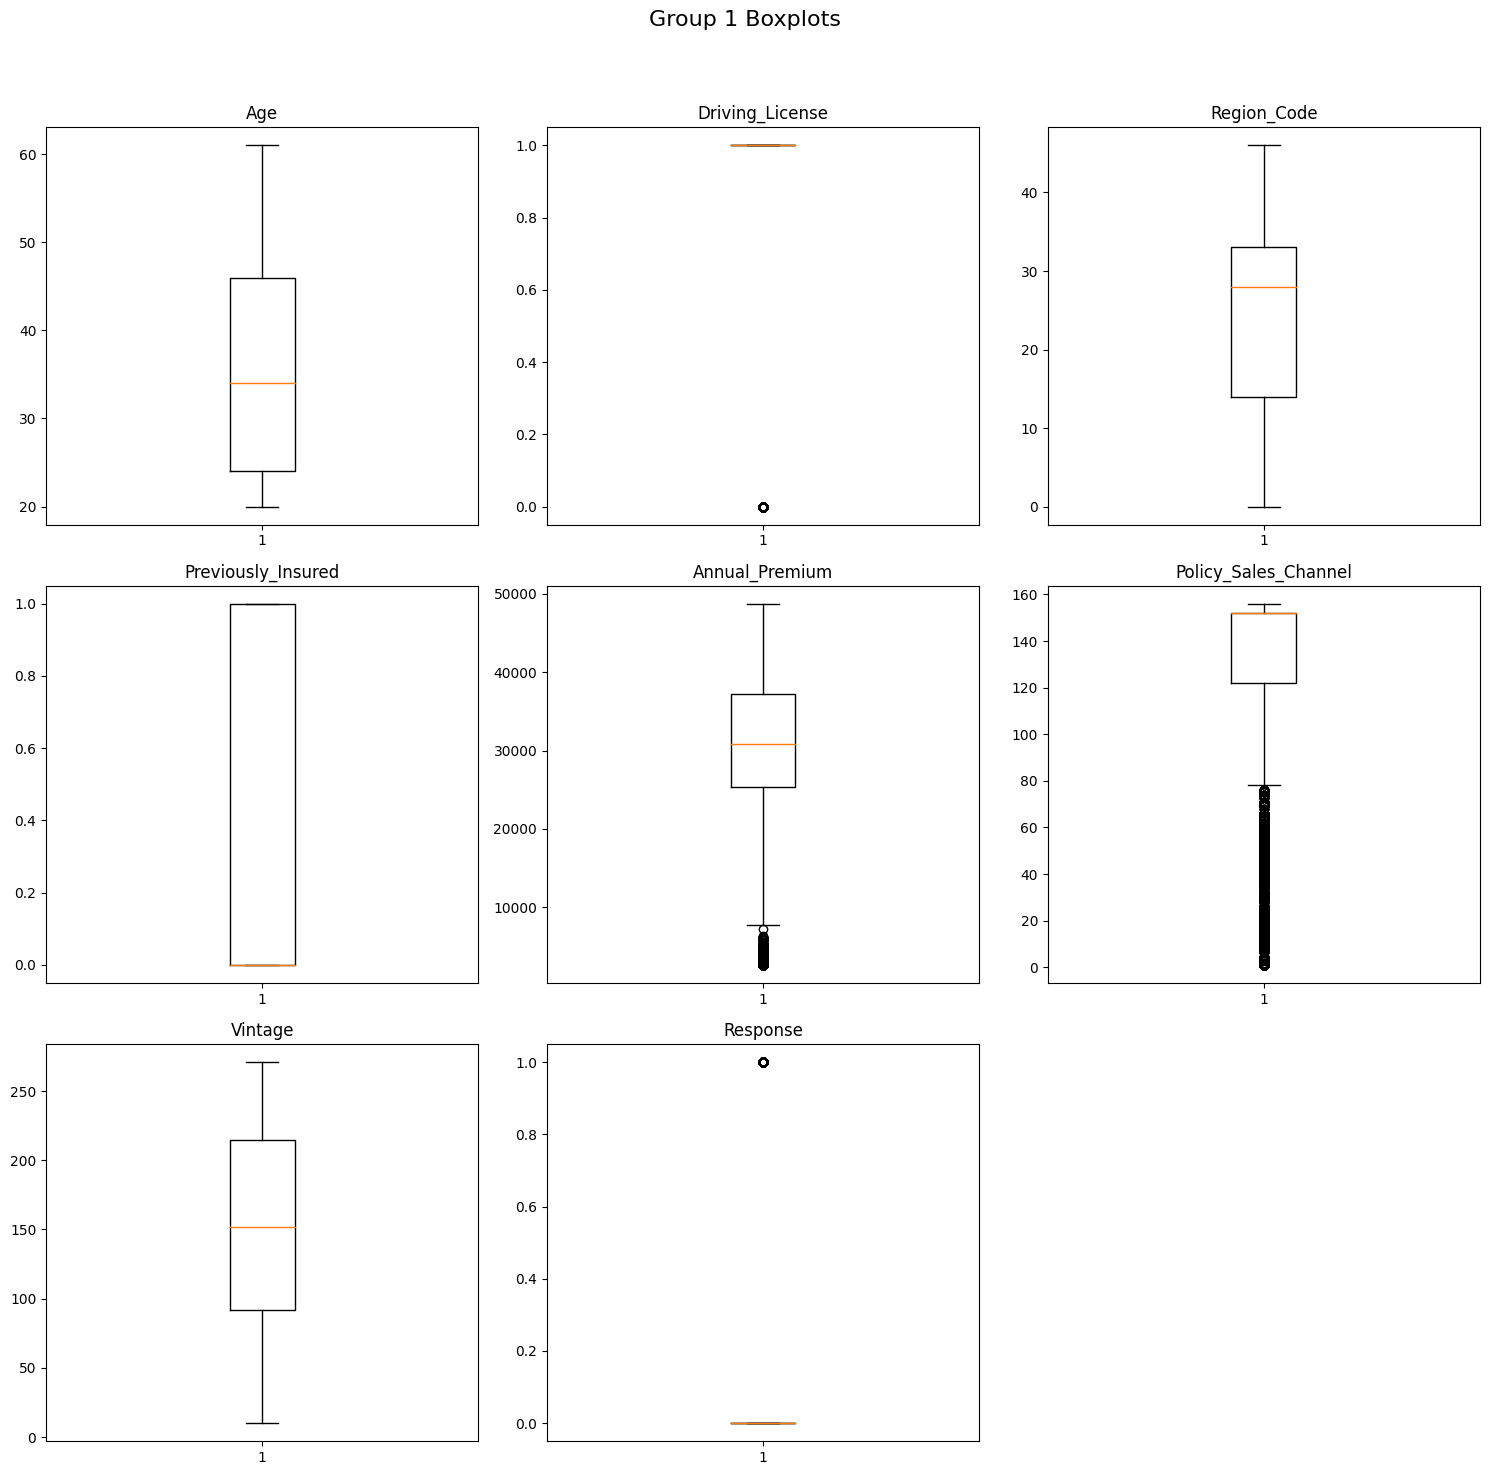

In [18]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

num_cols = len(numeric_cols)
num_plots_per_group = 9
num_groups = math.ceil(num_cols / num_plots_per_group)

for group in range(num_groups):
    cols_in_group = numeric_cols[group * num_plots_per_group:(group + 1) * num_plots_per_group]
    num_plots = len(cols_in_group)
    rows = math.ceil(num_plots / 3)
    fig, axs = plt.subplots(rows, 3, figsize=(15, 5 * rows))
    axs = axs.flatten() if num_plots > 1 else [axs]

    for i, col in enumerate(cols_in_group):
        axs[i].boxplot(df[col].dropna())
        axs[i].set_title(col)

    for i in range(num_plots, len(axs)):
        axs[i].set_visible(False)  

    plt.suptitle(f'Group {group + 1} Boxplots', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])

## <font color='#ff4d00'> Boşluk Varsa Doldurmaya, Düzeltilecek Kısım Varsa Düzeltmeye Başladık - If there is a gap, we started to fill it and if there is a part to be corrected, we started to correct it.

In [19]:
#for column in df.columns:
    # TR = Verideki her bir sütun için döngü başlatılıyor  
    # EN = Loops through each column in the dataframe

#    print(f"\nSütun: {column}")  
    # TR = Sütun ismi ekrana yazdırılıyor  
    # EN = Prints the column name

#    unique = df[column].dropna().unique()  
    # TR = NaN değerleri düşürerek benzersiz değerler elde ediliyor  
    # EN = Gets the unique values after dropping NaN values

#    if pd.api.types.is_numeric_dtype(df[column]):  
        # TR = Eğer sütundaki değerler sayısal ise, değerler sıralanıyor  
        # EN = If the column is of numeric type, the unique values are sorted
#        unique = sorted(unique)
        
#    nunique = len(unique)  # Benzersiz değerlerin sayısını hesapla
    # TR = Benzersiz değerlerin sayısını hesaplar  
    # EN = Calculates the number of unique values

#    print(f"Nunique Değerler: {nunique}")  
    # TR = Benzersiz değerlerin sayısını ekrana yazdırır  
    # EN = Prints the number of unique values

#    print(f"Unique Değerler: {unique}")  
    # TR = Benzersiz değerler ekrana yazdırılıyor  
    # EN = Prints the unique values



Sütun: Age
Nunique Değerler: 42
Unique Değerler: [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61]

Sütun: Driving_License
Nunique Değerler: 2
Unique Değerler: [0, 1]

Sütun: Region_Code
Nunique Değerler: 47
Unique Değerler: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0]

Sütun: Previously_Insured
Nunique Değerler: 2
Unique Değerler: [0, 1]

Sütun: Vehicle_Age
Nunique Değerler: 3
Unique Değerler: ['< 1 Year' '1-2 Year' '> 2 Years']

Sütun: Vehicle_Damage
Nunique Değerler: 2
Unique Değerler: ['No' 'Yes']

Sütun: Annual_Premium
Nunique Değerler: 31259
Unique Değerler: [2630.0, 2642.0, 2730.0, 2743.0, 2766.0, 2776.0, 2783.0, 2785.0, 2789.0, 2792.0, 

In [20]:
df.isnull().sum().sort_values(ascending=False)

Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [21]:
df['Vehicle_Damage']=df['Vehicle_Damage'].map({'Yes':0,'No':1})
df['Vehicle_Age']=df['Vehicle_Age'].map({'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2})

In [22]:
df.isnull().sum().sort_values(ascending=False)

Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7222760 entries, 2 to 11504797
Data columns (total 10 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Age                   int64  
 1   Driving_License       int64  
 2   Region_Code           float64
 3   Previously_Insured    int64  
 4   Vehicle_Age           int64  
 5   Vehicle_Damage        int64  
 6   Annual_Premium        float64
 7   Policy_Sales_Channel  float64
 8   Vintage               int64  
 9   Response              int64  
dtypes: float64(3), int64(7)
memory usage: 606.2 MB


## <font color=#e0c510> Verileri Görşelleştirme - Visualizing Data me

In [24]:
#for column in df.columns:
    # TR = Verideki her bir sütun için döngü başlatılıyor  
    # EN = Loops through each column in the dataframe

#    print(f"\nSütun: {column}")  
    # TR = Sütun ismi ekrana yazdırılıyor  
    # EN = Prints the column name

#    unique = df[column].dropna().unique()  
    # TR = NaN değerleri düşürerek benzersiz değerler elde ediliyor  
    # EN = Gets the unique values after dropping NaN values

#    if pd.api.types.is_numeric_dtype(df[column]):  
        # TR = Eğer sütundaki değerler sayısal ise, değerler sıralanıyor  
        # EN = If the column is of numeric type, the unique values are sorted
#        unique = sorted(unique)
        
#    nunique = len(unique)  # Benzersiz değerlerin sayısını hesapla
    # TR = Benzersiz değerlerin sayısını hesaplar  
    # EN = Calculates the number of unique values

#    print(f"Nunique Değerler: {nunique}")  
    # TR = Benzersiz değerlerin sayısını ekrana yazdırır  
    # EN = Prints the number of unique values

#    print(f"Unique Değerler: {unique}")  
    # TR = Benzersiz değerler ekrana yazdırılıyor  
    # EN = Prints the unique values



Sütun: Age
Nunique Değerler: 42
Unique Değerler: [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61]

Sütun: Driving_License
Nunique Değerler: 2
Unique Değerler: [0, 1]

Sütun: Region_Code
Nunique Değerler: 47
Unique Değerler: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0]

Sütun: Previously_Insured
Nunique Değerler: 2
Unique Değerler: [0, 1]

Sütun: Vehicle_Age
Nunique Değerler: 3
Unique Değerler: [0, 1, 2]

Sütun: Vehicle_Damage
Nunique Değerler: 2
Unique Değerler: [0, 1]

Sütun: Annual_Premium
Nunique Değerler: 31259
Unique Değerler: [2630.0, 2642.0, 2730.0, 2743.0, 2766.0, 2776.0, 2783.0, 2785.0, 2789.0, 2792.0, 2796.0, 2820.0, 2830.0, 2864.0, 

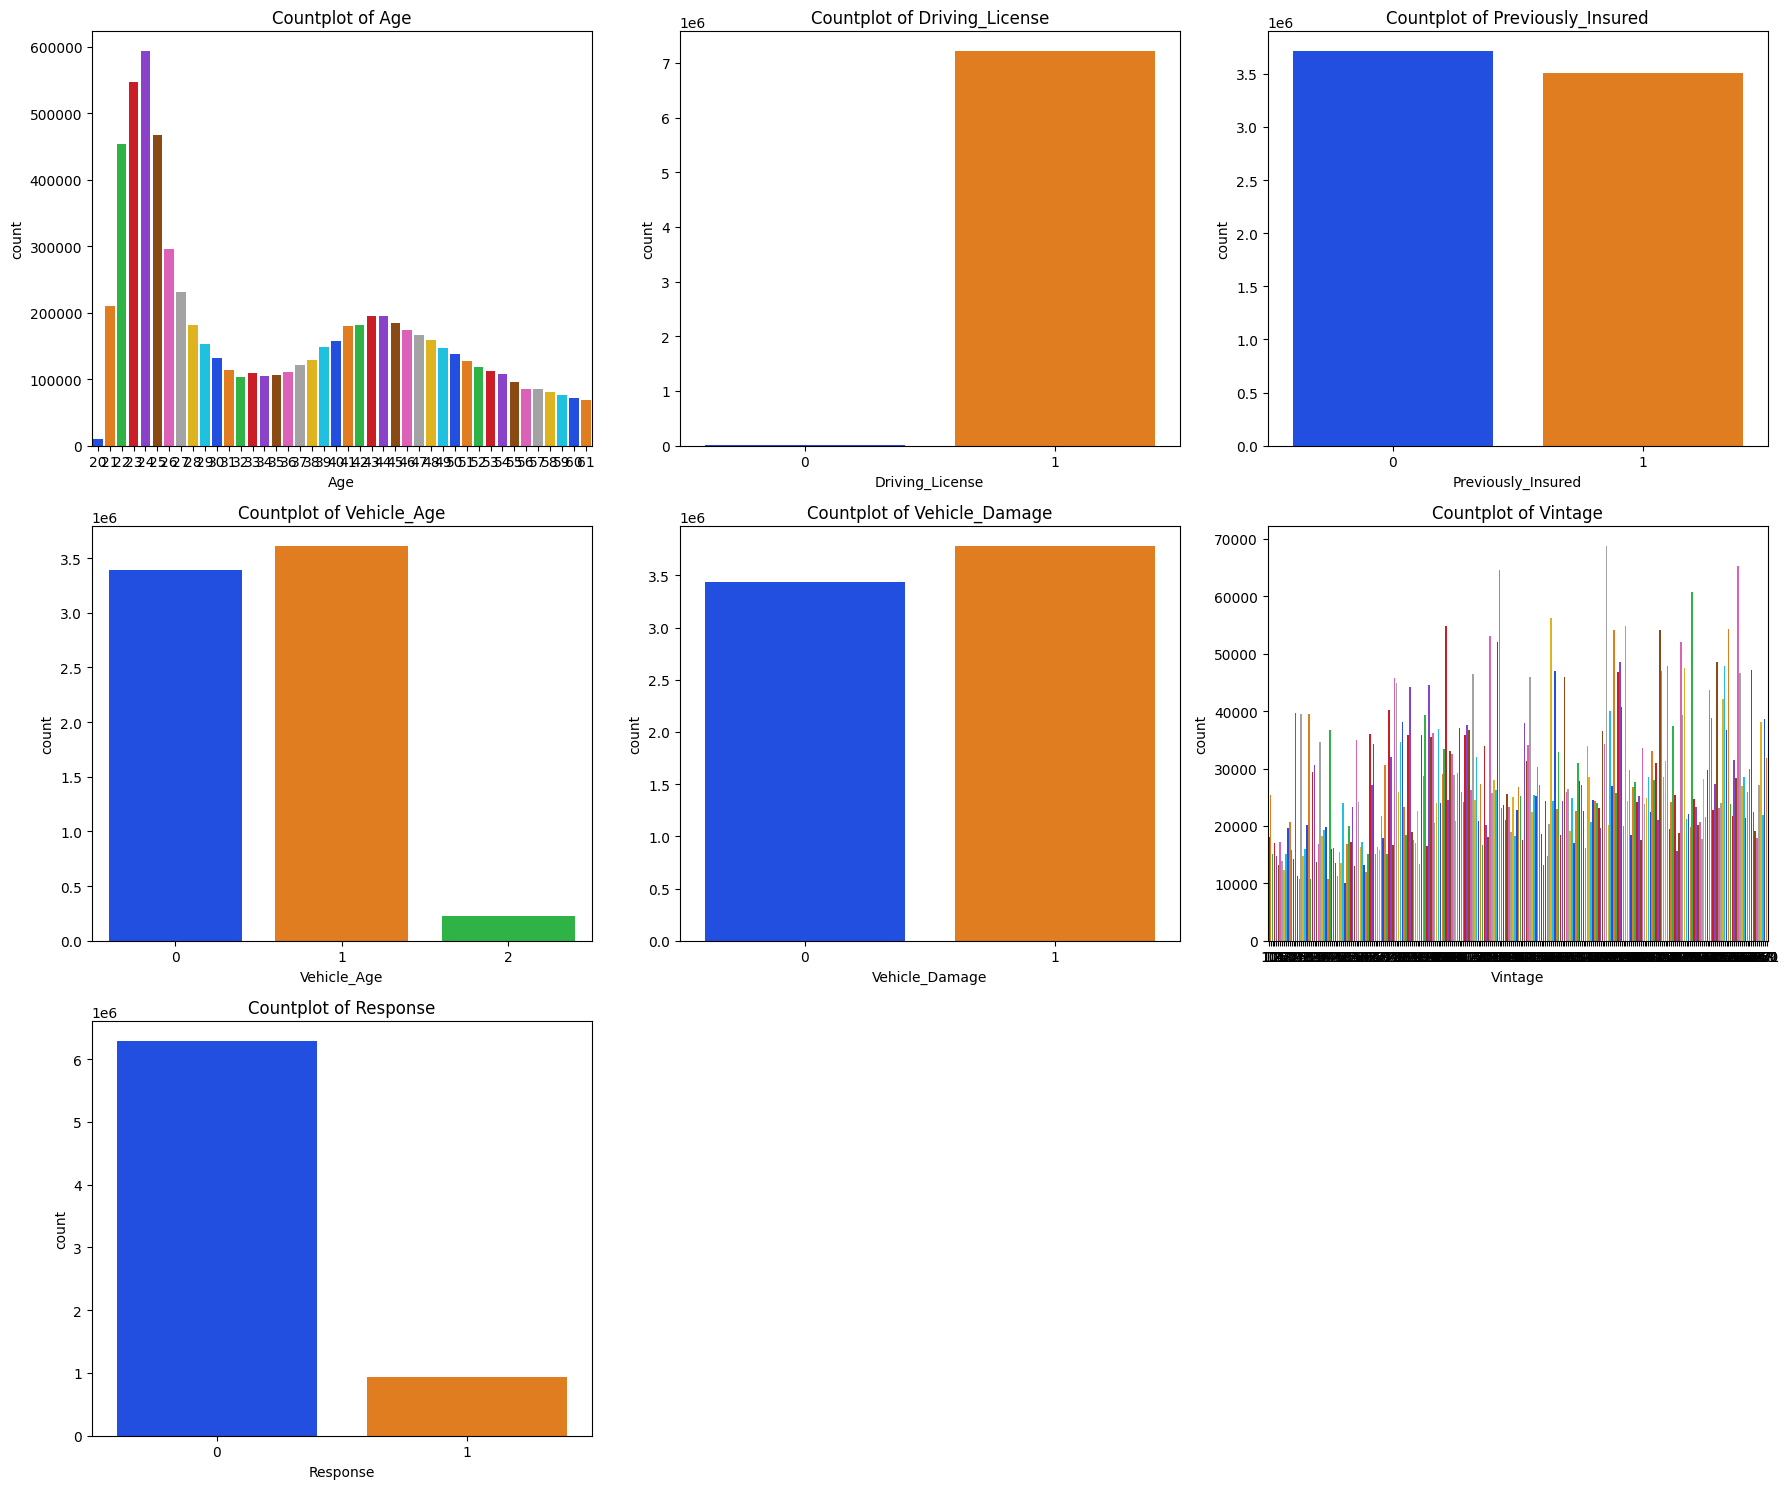

In [25]:
int_columns = df.select_dtypes(include=['int64']).columns
# TR = İnt veri türündeki sütunları alır  
# EN = Selects columns with int data type

columns = [col for col in df.columns if col in int_columns] 
# TR = (in df.columns) df DataFrame içindeki (col for col)her sütuna bak.
# TR = (if col in object_columns) istenilen kolonlara bakar.

# EN = (in df.columns) Look at each column in df DataFrame (col for col).
# EN = (if col in object_columns) looks at the desired columns.

num_columns = len(columns)
# TR = sütun sayısını okuyup, num_columns değişkenine atadım.
# EN = I read the number of columns and assigned it to the num_columns variable.

fig, axes = plt.subplots(nrows=(num_columns // 3) + 1, ncols=3, figsize=(18, (num_columns // 3 + 1) * 5))
# TR = nrows=(num_columns // 3) + 1: Bu, oluşturulacak alt grafiklerin (subplot'ların) satır sayısını belirler.
# TR = num_columns // 3, toplam sütun sayısının 3'e bölünmesiyle elde edilen tam sayı değerdir. + 1 ise, sütun sayısı 3'e tam bölünmüyorsa ekstra bir satır ekler.
# TR = ncols=3: Bu, her satırda kaç tane alt grafik olacağını belirler. Bu örnekte, her satırda 3 alt grafik olacak şekilde ayarlanmıştır.  
# TR = figsize=(18, (num_columns // 3 + 1) * 5): Bu, oluşturulacak figürün (grafiklerin tümünün bulunduğu büyük alanın) boyutlarını ayarlar.
# TR = figsize parametresi, genişlik ve yükseklik değerlerini (18, (num_columns // 3 + 1) * 5) şeklinde alır. 
# TR = Genişlik 18 inç, yükseklik ise her satır için 5 inç olacak şekilde hesaplanır.

# EN = nrows=(num_columns // 3) + 1: This determines the number of rows of subplots to be created.
# EN = num_columns // 3 is the integer value obtained by dividing the total number of columns by 3. + 1 adds an extra row if the column count is not perfectly divisible by 3.
# EN = ncols=3: This determines how many subplots will be in each row. In this example, there will be 3 subplots per row.
# EN = figsize=(18, (num_columns // 3 + 1) * 5): This sets the size of the figure (the large area containing all the plots).
# EN = The figsize parameter takes the width and height values as (18, (num_columns // 3 + 1) * 5).
# EN = The width is 18 inches, and the height is calculated as 5 inches per row.


for i, column in enumerate(columns):  
    row = i // 3  
    # TR = Her sütunun hangi satırda gösterileceğini hesaplar (3 sütundan birinde)  
    # EN = Calculates which row each column should be displayed in (one of three columns)

    col = i % 3  
    # TR = Her sütunun hangi sütunda gösterileceğini hesaplar (0'dan 2'ye kadar)  
    # EN = Calculates which column each plot should be placed in (from 0 to 2)

    sns.countplot(data=df, x=column, ax=axes[row, col],palette='bright')
    # TR = Kategorik verilerin her bir sınıfındaki gözlem sayısını görselleştirmek için kullanılır ve her kategorinin frekansını çubuklarla gösterir.
    # EN = It is used to visualize the number of observations in each class of categorical data and shows the frequency of each category with bars.

    # TR = (data=df) Veriyi df adlı DataFrame alacak.
    # TR = (x=column) column değişkenindeki sütunları alıp yatay eksenine eşitleyecek
    # TR = (ax=axes[row, col]) Tablonun yukarıdan ve soldan kaçıncı sırada duracağını beliler

    # EN = (data=df) Will take the data from the DataFrame named df.
    # EN = (x=column) Will take the columns in the column variable and assign them to the x-axi
    # EN = (ax=axes[row, col]) Specifies the position in the grid, indicating which row and column it will be placed in.

    axes[row, col].set_title(f'Countplot of {column}')  
    # TR = Grafiğin başlığını, ilgili sütun adı ile ayarlar  
    # EN = Sets the title of the plot to the name of the column

    axs = axs.flatten() if num_plots > 1 else [axs]  
    # TR = Grafik pencerelerini düzleştirir (eğer tek değilse)  
    # EN = Flattens the plot axes (if there’s more than one)


for j in range(i+1, len(axes.flat)):  
    # TR = Kullanılmayan alt grafikler (subplots) siliniyor  
    # EN = Removing unused subplots

    fig.delaxes(axes.flat[j])  
    # TR = Belirtilen alt grafiği (subplot) siler  
    # EN = Deletes the specified subplot from the figure

plt.tight_layout()  
# TR = Grafiklerin düzenli görünmesi için yerleşim ayarlarını yapar  
# EN = Adjusts the layout for a tidy appearance

plt.show()  
# TR = Grafiği ekranda gösterir  
# EN = Displays the plot on the screen

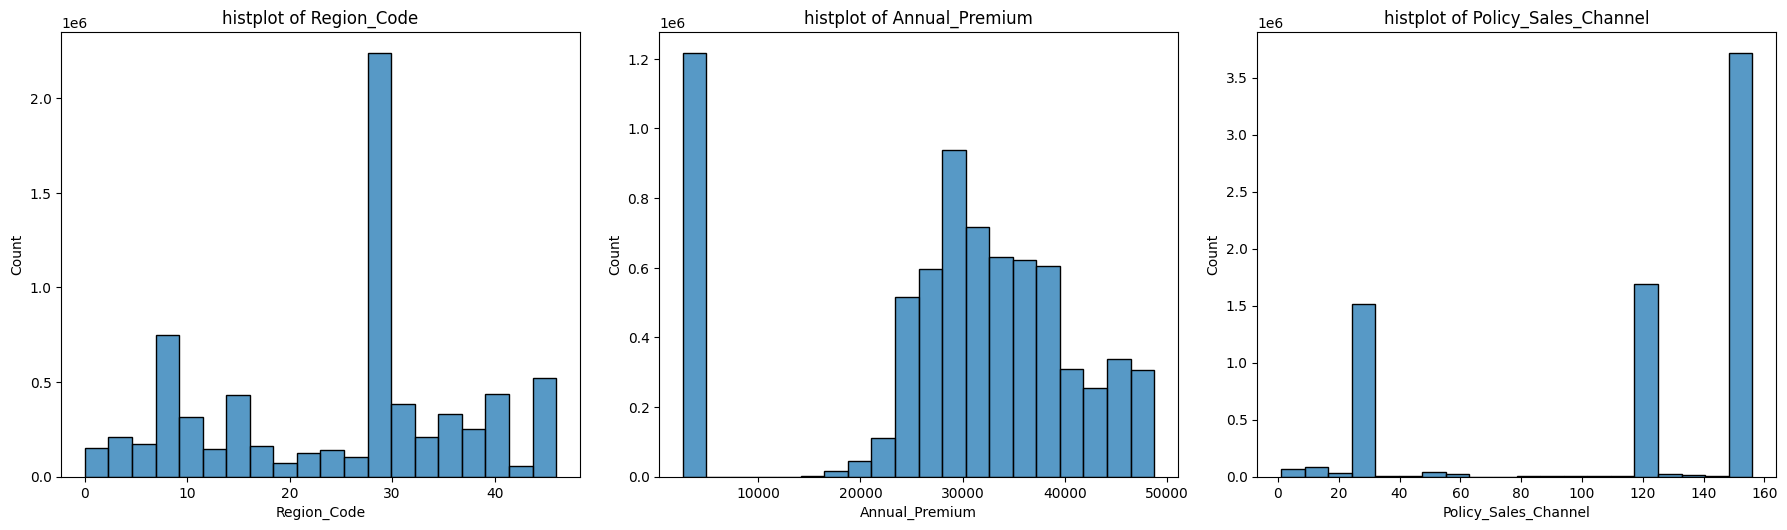

In [26]:
float_columns = df.select_dtypes(include=['float64']).columns
# TR = Float veri türündeki sütunları alır  
# EN = Selects columns with float data type

columns = [col for col in df.columns if col in float_columns] 
# TR = (in df.columns) df DataFrame içindeki (col for col)her sütuna bak.
# TR = (if col in object_columns) istenilen kolonlara bakar.

# EN = (in df.columns) Look at each column in df DataFrame (col for col).
# EN = (if col in object_columns) looks at the desired columns.

num_columns = len(columns)
# TR = sütun sayısını okuyup, num_columns değişkenine atadım.
# EN = I read the number of columns and assigned it to the num_columns variable.

fig, axes = plt.subplots(nrows=(num_columns // 3) + 1, ncols=3, figsize=(18, (num_columns // 3 + 1) * 5))
# TR = nrows=(num_columns // 3) + 1: Bu, oluşturulacak alt grafiklerin (subplot'ların) satır sayısını belirler.
# TR = num_columns // 3, toplam sütun sayısının 3'e bölünmesiyle elde edilen tam sayı değerdir. + 1 ise, sütun sayısı 3'e tam bölünmüyorsa ekstra bir satır ekler.
# TR = ncols=3: Bu, her satırda kaç tane alt grafik olacağını belirler. Bu örnekte, her satırda 3 alt grafik olacak şekilde ayarlanmıştır.  
# TR = figsize=(18, (num_columns // 3 + 1) * 5): Bu, oluşturulacak figürün (grafiklerin tümünün bulunduğu büyük alanın) boyutlarını ayarlar.
# TR = figsize parametresi, genişlik ve yükseklik değerlerini (18, (num_columns // 3 + 1) * 5) şeklinde alır. 
# TR = Genişlik 18 inç, yükseklik ise her satır için 5 inç olacak şekilde hesaplanır.

# EN = nrows=(num_columns // 3) + 1: This determines the number of rows of subplots to be created.
# EN = num_columns // 3 is the integer value obtained by dividing the total number of columns by 3. + 1 adds an extra row if the column count is not perfectly divisible by 3.
# EN = ncols=3: This determines how many subplots will be in each row. In this example, there will be 3 subplots per row.
# EN = figsize=(18, (num_columns // 3 + 1) * 5): This sets the size of the figure (the large area containing all the plots).
# EN = The figsize parameter takes the width and height values as (18, (num_columns // 3 + 1) * 5).
# EN = The width is 18 inches, and the height is calculated as 5 inches per row.


for i, column in enumerate(columns):  
    row = i // 3  
    # TR = Her sütunun hangi satırda gösterileceğini hesaplar (3 sütundan birinde)  
    # EN = Calculates which row each column should be displayed in (one of three columns)

    col = i % 3  
    # TR = Her sütunun hangi sütunda gösterileceğini hesaplar (0'dan 2'ye kadar)  
    # EN = Calculates which column each plot should be placed in (from 0 to 2)

    sns.histplot(data=df,x=column, bins=20, ax=axes[row, col])  
    # TR = Belirli bir değişkenin dağılımını görmek için kullanılır. Bu grafik, veri setindeki bir değişkenin frekanslarını veya yoğunluğunu analiz etmenizi sağlar.
    # EN = It is used to see the distribution of a particular variable. This plot allows you to analyze the frequencies or density of a variable in the dataset.

    # TR = (data=df) Veriyi df adlı DataFrame alacak.
    # TR = (x=column) column değişkenindeki sütunları alıp yatay eksenine eşitleyecek
    # TR = (bins=20) Veri ayarını 20 eşit genişlikte bölüme ayırmış olursunuz. 
    # TR = (ax=axes[row, col]) Tablonun yukarıdan ve soldan kaçıncı sırada duracağını beliler
    
    # EN = (data=df) Will take the data from the DataFrame named df.
    # EN = (x=column) Will take the columns in the column variable and assign them to the x-axi
    # EN = (bins=20) You will divide the data set into 20 equally wide sections.
    # EN = (ax=axes[row, col]) Specifies the position in the grid, indicating which row and column it will be placed in.

    axes[row, col].set_title(f'histplot of {column}')  
    # TR = Grafiğin başlığını, ilgili sütun adı ile ayarlar  
    # EN = Sets the title of the plot to the name of the column

    axs = axs.flatten() if num_plots > 1 else [axs]  
    # TR = Grafik pencerelerini düzleştirir (eğer tek değilse)  
    # EN = Flattens the plot axes (if there’s more than one)


for j in range(i+1, len(axes.flat)):  
    # TR = Kullanılmayan alt grafikler (subplots) siliniyor  
    # EN = Removing unused subplots

    fig.delaxes(axes.flat[j])  
    # TR = Belirtilen alt grafiği (subplot) siler  
    # EN = Deletes the specified subplot from the figure

plt.tight_layout()  
# TR = Grafiklerin düzenli görünmesi için yerleşim ayarlarını yapar  
# EN = Adjusts the layout for a tidy appearance

plt.show()  
# TR = Grafiği ekranda gösterir  
# EN = Displays the plot on the screen

## <font color='#0F52BA'> Öznitelik Mühendisliği - Feature Engineering

### <font color=#007fff> Model - Modelling 

In [27]:
x=df.drop('Response',axis=1)
y=df[['Response']]

In [28]:
x=pd.get_dummies(x,drop_first=True) 
# Tr =  kategorik değişkenlerin sayısal değişkenlere dönüştürülmesi için kullanılır. 
# En = It is used to convert categorical variables into numerical variables.

In [29]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.20,random_state=42)
# TR = modelimizi eğittik. 
# EN = We trained our model.

In [30]:
scaler = MinMaxScaler()
# TR = Avantajları:
# TR = Özellikle dağılımı belirli bir aralığa sığdırmak istediğinizde kullanışlıdır.
# TR = Daha hızlı ve basit bir hesaplama yöntemi.
# TR = Dezavantajları:
# TR = Aykırı (outlier) değerlerden etkilenir. Aşırı büyük veya küçük değerler, ölçeklendirmeyi bozabilir.

# EN = Advantages:
# EN = Useful when you want to fit the distribution into a specific range.
# EN = Faster and simpler calculation method.
# EN = Disadvantages:
# EN = Affected by outliers. Extremely large or small values can distort the scaling.

x_train = scaler.fit_transform(x_train)
# TR = Verileri ölçekleyerek, modelin daha hızlı ve etkili öğrenmesini sağlamak için tüm özellikleri aynı aralığa getiriyoruz.
# EN = By scaling the data, we bring all the features into the same range to allow the model to learn faster and more effectively.

x_test = scaler.transform(x_test)
# TR = Test verilerini eğitimde kullanılan aynı ölçekle dönüştürerek modelin test verileri üzerinde doğru tahminler yapmasını sağlar.
# EN = It enables the model to make accurate predictions on the test data by transforming the test data to the same scale used in training.

In [31]:
model=Sequential()
model.add(Dense(2560,activation='relu',input_dim=x_train.shape[1]))
# TR = Bu katman, tüm giriş nöronlarına bağlantı kurar ve her nöronun ağırlıklarını öğrenir. 56 nöron var.
# Aktivasyon fonksiyonunu ReLU (Rectified Linear Unit) olarak ayarlar. ReLU fonksiyonu, negatif değerleri sıfıra dönüştürür ve pozitif değerleri olduğu gibi bırakır.
# EN = This layer connects all input neurons and learns the weights of each neuron. There are 56 neurons.
# Sets the activation function to ReLU (Rectified Linear Unit). The ReLU function converts negative values ​​to zero and leaves positive values ​​as is.

model.add(BatchNormalization())
# TR = Bu katman, modelin eğitim sürecini daha stabil hale getirmek için kullanılır.
# EN = This layer is used to make the training process of the model more stable.

model.add(Dropout(0.2))
# TR = Derin öğrenme modelinde aşırı uyumu (overfitting) azaltmak için kullanılır. Genelde 0.2 ile 0.5 arasında olur.
# EN = It is used to reduce overfitting in the deep learning model. It is generally between 0.2 and 0.5.

model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())

model.add(Dense(32,activation='relu'))
model.add(BatchNormalization())

model.add(Dense(12,activation='relu'))
model.add(BatchNormalization())

model.add(Flatten())
# TR = Derin öğrenme modelindeki çok boyutlu (2D, 3D vb.) verileri tek boyutlu bir vektöre dönüştürür.
# EN = It converts multidimensional (2D, 3D, etc.) data in the deep learning model into a one-dimensional vector.

model.add(Dense(1, activation='sigmoid'))
# TR = Sigmoid fonksiyonu, çıktı değerini 0 ile 1 arasında sınırlayarak iki sınıflı (binary) sınıflandırma problemleri için kullanılır.
# EN = The sigmoid function is used for binary classification problems, limiting the output value between 0 and 1.

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# TR = EarlyStopping ekleyin: Eğitim sırasında model performansı iyileşmediğinde erken durması için kullanıyoruz.
# EN = Add EarlyStopping: We use it to stop early when model performance does not improve during training.

# TR = val_loss 10 epoch boyunca iyileşmezse eğitimi durduruyor ve en iyi ağırlıkları geri yüklüyor.
# EN = If val_loss does not improve for 10 epochs, it stops training and restores the best weights.

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
# TR = İkili sınıflandırma (çıktı katmanı sigmoid aktivasyon kullanır).
# TR = Tahmin edilen olasılık ile gerçek ikili etiketler arasındaki farkı ölçer.
# TR = optimizer='adam': Adam (Adaptive Moment Estimation) optimizasyon algoritması, modelin ağırlıklarını güncellerken kullanılan bir yöntemdir.
# TR = metrics=['accuracy']: Modelin performansını değerlendirmek için kullanılan bir ölçümdür. Doğru sınıflandırılan örneklerin toplam örneklere oranını hesaplar.

# EN = Binary classification (output layer uses a sigmoid activation).
# EN = Measures the difference between the predicted probability and the actual binary labels.
# EN = optimizer='adam': Adam (Adaptive Moment Estimation) optimization algorithm is a method used when updating the weights of the model.
# EN = metrics=['accuracy']: A metric used to evaluate the performance of the model. It calculates the ratio of correctly classified examples to total examples.

history=model.fit(x_train, y_train, validation_split=0.2, batch_size=128, epochs=100, callbacks=[early_stopping])
# TR = Modeli 100 epoch boyunca eğitiyoruz, fakat EarlyStopping ile durdurulabilir. Batch boyutu 128 olarak belirlenmiş.
# EN = We train the model for 100 epochs, but it can be stopped with EarlyStopping. Batch size is set to 128.

Epoch 1/100


I0000 00:00:1727710182.542311     112 service.cc:145] XLA service 0x7ea28000ab20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727710182.542365     112 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1727710182.542368     112 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


   64/36114 ━━━━━━━━━━━━━━━━━━━━ 1:29 2ms/step - accuracy: 0.6508 - loss: 0.6690

I0000 00:00:1727710186.823513     112 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


36114/36114 ━━━━━━━━━━━━━━━━━━━━ 111s 3ms/step - accuracy: 0.8663 - loss: 0.2828 - val_accuracy: 0.8704 - val_loss: 0.2692
Epoch 2/100
36114/36114 ━━━━━━━━━━━━━━━━━━━━ 98s 3ms/step - accuracy: 0.8705 - loss: 0.2698 - val_accuracy: 0.8706 - val_loss: 0.2686
Epoch 3/100
36114/36114 ━━━━━━━━━━━━━━━━━━━━ 98s 3ms/step - accuracy: 0.8707 - loss: 0.2689 - val_accuracy: 0.8706 - val_loss: 0.2687
Epoch 4/100
36114/36114 ━━━━━━━━━━━━━━━━━━━━ 98s 3ms/step - accuracy: 0.8704 - loss: 0.2687 - val_accuracy: 0.8706 - val_loss: 0.2681
Epoch 5/100
36114/36114 ━━━━━━━━━━━━━━━━━━━━ 98s 3ms/step - accuracy: 0.8708 - loss: 0.2685 - val_accuracy: 0.8706 - val_loss: 0.2680
Epoch 6/100
36114/36114 ━━━━━━━━━━━━━━━━━━━━ 99s 3ms/step - accuracy: 0.8708 - loss: 0.2684 - val_accuracy: 0.8705 - val_loss: 0.2685
Epoch 7/100
36114/36114 ━━━━━━━━━━━━━━━━━━━━ 99s 3ms/step - accuracy: 0.8707 - loss: 0.2683 - val_accuracy: 0.8705 - val_loss: 0.2689
Epoch 8/100
36114/36114 ━━━━━━━━━━━━━━━━━━━━ 99s 3ms/step - accuracy: 0.8

In [32]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 2560)           │        25,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2560)           │        10,240 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2560)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       327,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 12)             │           396 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12)             │            48 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,114,829 (4.25 MB)

 Trainable params: 369,745 (1.41 MB)

 Non-trainable params: 5,592 (21.84 KB)

 Optimizer params: 739,492 (2.82 MB)

In [33]:
test_loss, test_acc = model.evaluate(x_test, y_test)
# TR = test_loss değişkeni, test verileri üzerinde hesaplanan kayıp değerini içerir. test_acc değişkeni, test verileri üzerinde hesaplanan doğruluk değerini içerir.
# EN = The test_loss variable contains the loss value calculated on the test data. The test_acc variable contains the accuracy value calculated on the test data.

print(f"Test doğruluğu: {test_acc:.4f}")

45143/45143 ━━━━━━━━━━━━━━━━━━━━ 65s 1ms/step - accuracy: 0.8716 - loss: 0.2652
Test doğruluğu: 0.8717


In [34]:
pred=model.predict(x_test)
# TR = modeli x_test ile predict özelliği ile tahmin ettik. predict=tahmin demek. Dahmin edip pred eşitledik. 
# EN = We predicted the model with x_test and the predict feature. predict=means prediction. We guessed and equalized the pred.

45143/45143 ━━━━━━━━━━━━━━━━━━━━ 59s 1ms/step


In [35]:
pred

array([[4.2944436e-04],
       [7.5001001e-02],
       [1.5232167e-01],
       ...,
       [5.0186980e-01],
       [6.6173941e-02],
       [1.3798541e-04]], dtype=float32)

In [36]:
pred = np.argmax(pred, axis=1)
pred

array([0, 0, 0, ..., 0, 0, 0])

In [37]:
y_test

,Response
7740248,0
3233560,0
1129640,0
10450014,0
5159235,0
...,...
7613438,0
2014883,0
8309858,0
60777,0


In [38]:
#y_test = np.argmax(y_test, axis=1)
y_test

,Response
7740248,0
3233560,0
1129640,0
10450014,0
5159235,0
...,...
7613438,0
2014883,0
8309858,0
60777,0


In [39]:
accuracy_score(y_test, pred)
# TR = accuracy_score fonksiyonu ile y_test, pred kullanarak sonucumuzu bulduk.
# EN = We found our result using the accuracy_score function and y_test, pred.

0.8709696847188609

In [40]:
confusion_matrix(y_test, pred)
# TR = confusion_matrix fonksiyonu ile y_test, pred kullanarak ne kadarını yanlış tahmin ettiğimizi buluyoruz
# EN = Using the confusion_matrix function and y_test, pred, we find out how much we guessed wrong.

# TR = 4 sayı değeri veriyor bize. Sol üst ve sağ alt doğru tahmin, sağ üst ve sol alt yanlış tahmin. 
# EN = It gives us 4 number values. Upper left and lower right are correct guesses, upper right and lower left are incorrect guesses.

array([[1258161,       0],
       [ 186391,       0]])

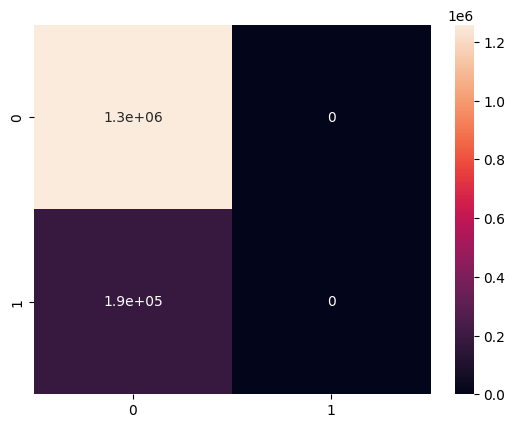

In [41]:
sns.heatmap(confusion_matrix(y_test, pred),annot=True);
# TR = Yukarıdakinin görsel versiyonu.
# EN = Visual version of the above.

In [42]:
print(classification_report(y_test, pred))
# TR = print içinde yazdık yoksa sayıların sıralanması bozuluyor.
# EN = We wrote it in print, otherwise the order of the numbers will be disrupted.

# TR = classification_report ile y_test, pred kullanarak precision, recall, f1-score ve support ulaştık.
# EN = We achieved precision, recall, f1-score and support using classification_report and y_test, pred.

# TR = Precision (Kesinlik): Doğru olarak pozitif tahmin edilen örneklerin, toplam pozitif tahmin edilen örnekler içindeki oranını gösterir. Yani, modelin pozitif sınıfı ne kadar doğru tahmin ettiğini ölçer.
# EN = Precision (Precision): It shows the ratio of correctly predicted positive samples among the total positive predicted samples. That is, it measures how accurately the model predicts the positive class.

# TR = Recall (Duyarlılık): Gerçek pozitif örneklerin, toplam pozitif örnekler içindeki oranını gösterir. Modelin pozitif sınıfı ne kadar iyi bulduğunu ölçer.
# EN = Recall (Sensitivity): Shows the ratio of true positive samples in total positive samples. It measures how well the model finds the positive class.

# TR = F1-score: Precision ve recall'un harmonik ortalamasıdır. Hem precision hem de recall'u dikkate alarak modelin genel performansını özetler.
# EN = F1-score: It is the harmonic mean of precision and recall. It summarizes the overall performance of the model, taking into account both precision and recall.

# TR = Support: Her sınıftan kaç örneğin bulunduğunu gösterir. Yani, gerçek etiketlerde her bir sınıfa ait kaç örnek olduğunu ifade eder.
# EN = Support: Shows how many examples of each class are available. That is, it expresses how many examples of each class there are in the real labels.

              precision    recall  f1-score   support

           0       0.87      1.00      0.93   1258161
           1       0.00      0.00      0.00    186391

    accuracy                           0.87   1444552
   macro avg       0.44      0.50      0.47   1444552
weighted avg       0.76      0.87      0.81   1444552



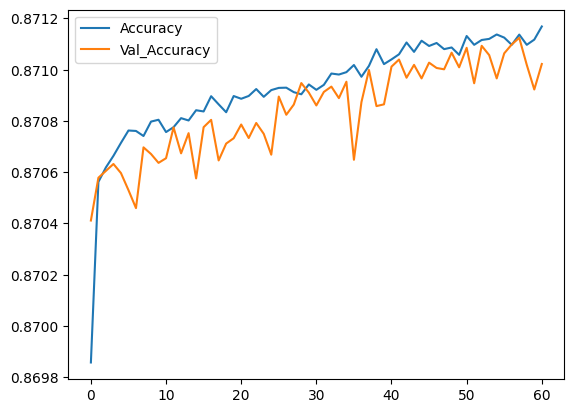

In [43]:
plt.plot(history.history['accuracy'],label='Accuracy')
plt.plot(history.history['val_accuracy'],label='Val_Accuracy')
plt.legend();

In [44]:
pickle.dump(model,open('Sigorta.pkl','wb'))